# Build the model

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
import scipy.stats as stats
import time
import matplotlib.dates as mdates
import models

sns.set(style="whitegrid")

The data contains a number of variables. We decided to use the following for our regression model:
* 

In [3]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

In [4]:
all_listings = con.execute('SELECT * from all_listings').df()

In [5]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [6]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [23]:
all_listings.isna().any()
all_listings.columns[all_listings.isna().any()].tolist()

['name',
 'description',
 'neighborhood_overview',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'reviews_per_month']

In [61]:
filtered_listings = all_listings[all_listings[["host_listings_count", "latitude", "longitude", 
                                    "accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews_ltm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness","review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"]].notnull().all(1)]

In [62]:
correlations(filtered_listings, "price", ["host_listings_count", "latitude", "longitude", 
                                    "accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews_ltm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness","review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"])

,feature,r,rho
0,host_listings_count,0.022220,0.039772
1,latitude,-0.046396,-0.135815
2,longitude,-0.074999,-0.144882
3,accommodates,0.354629,0.613836
4,bedrooms,0.378315,0.606244
5,beds,0.289953,0.522529
6,minimum_nights,0.008287,0.042882
7,maximum_nights,0.005783,0.070606
8,number_of_reviews_ltm,-0.014083,0.131187
9,number_of_reviews,-0.049707,-0.018265


For our null model: 

In [54]:
filtered_listings.price.describe()

count    19061.000000
mean       167.485914
std        244.915875
min          9.000000
25%         81.000000
50%        121.000000
75%        193.000000
max      10000.000000
Name: price, dtype: float64

The minimum price is 9, the highest is 10000. The mean is 167 with a standard deviation of 244.91. In this case, 244.92 will be our $\sigma$ for the Null model.

In [27]:
model = "price ~ host_listings_count + latitude + longitude + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews_ltm + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month"
result1 = models.bootstrap_linear_regression(model, data=filtered_listings)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-30177.74,-36511.12,-21941.59
host_listings_count,$\beta_{1}$,0.01,0.00,0.01
latitude,$\beta_{2}$,-723.46,-895.16,-543.01
longitude,$\beta_{3}$,-755.64,-845.93,-670.54
accommodates,$\beta_{4}$,19.44,16.35,22.09
bedrooms,$\beta_{5}$,69.91,63.72,74.99
beds,$\beta_{6}$,-10.57,-14.42,-5.59
minimum_nights,$\beta_{7}$,0.09,-0.02,0.19
maximum_nights,$\beta_{8}$,0.00,-0.00,0.00


The correlation coefficient is 17% which is very low. The error ( 𝜎 ) is 222.57, only slightly lower than the Null model 244.92.

Let's look at the residuals. 

In [36]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,20))

    variables = ["host_listings_count", "latitude", "longitude", 
                                    "accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews_ltm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness","review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"]

    plots = len( variables)
    rows = (plots // 4) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 4, i + 1)

        keyed_values = sorted(zip(filtered_listings[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

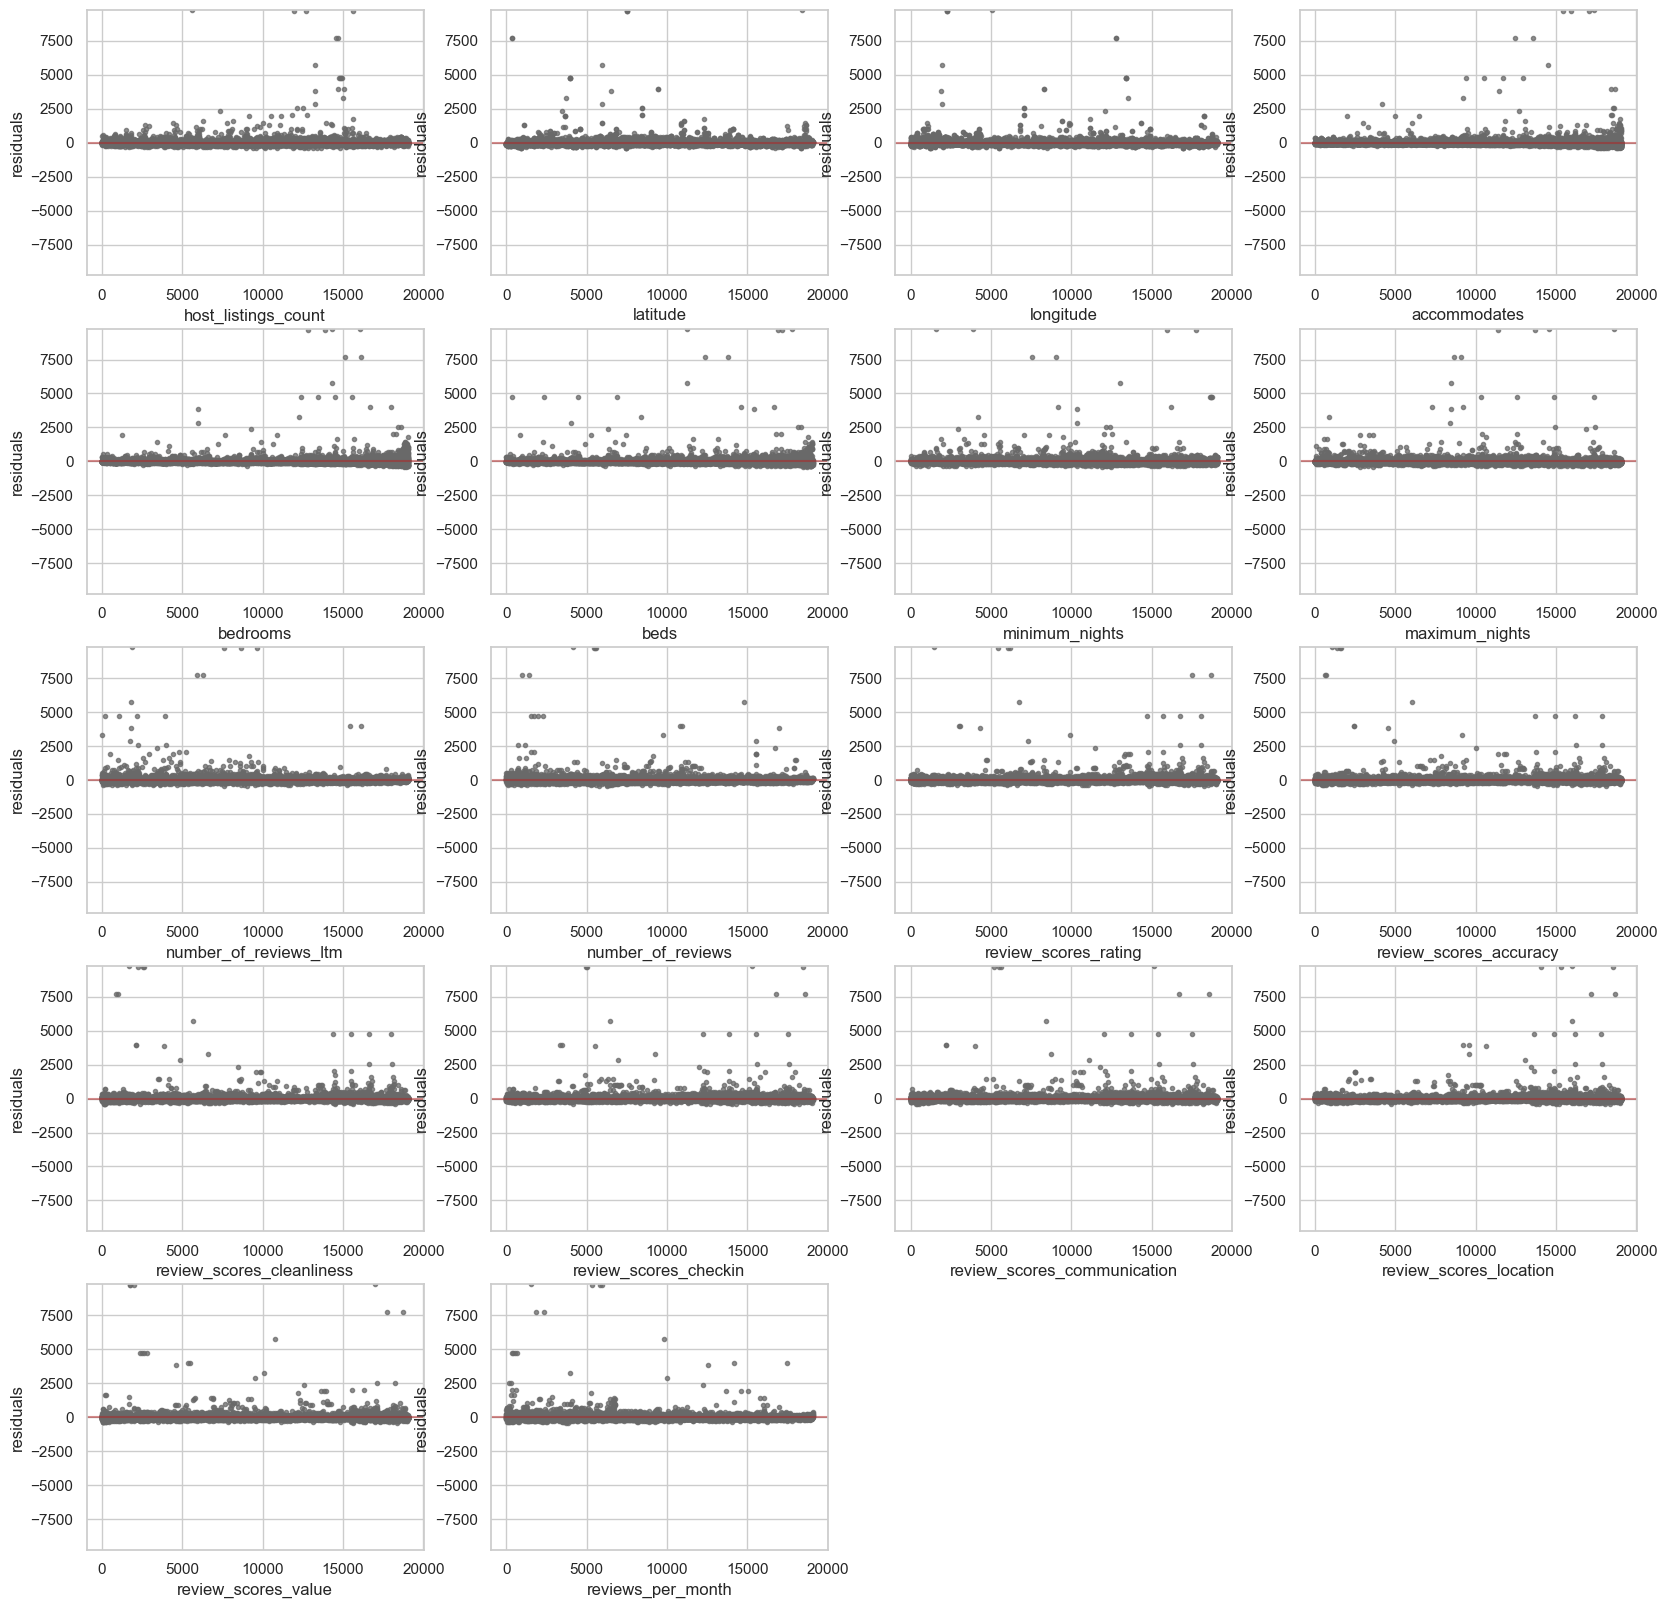

In [37]:
residuals1 = plot_residuals(result1, ["host_listings_count", "latitude", "longitude", 
                                    "accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews_ltm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness","review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"])

I'm going to clean prices that are above 1000 as that only represents 1% of the data but skews the model.

In [66]:
df2 = filtered_listings[filtered_listings['price'] <= 1000]

We removed just 92 values which is 0.4% of that price data. 

Let's check out the new null model. 

In [67]:
df2.price.describe()

count    18969.000000
mean       156.895145
std        121.971542
min          9.000000
25%         81.000000
50%        120.000000
75%        190.000000
max       1000.000000
Name: price, dtype: float64

The new null model has a min of 9 and a max of 1000 with an std of 121.97 and mean of 156.89. 

Let's run our model again with the updated price values. 

In [68]:
model = "price ~ host_listings_count + latitude + longitude + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews_ltm + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month"
result2 = models.bootstrap_linear_regression(model, data=df2)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-27386.82,-31240.37,-23820.16
host_listings_count,$\beta_{1}$,0.01,0.01,0.02
latitude,$\beta_{2}$,-595.77,-633.74,-542.62
longitude,$\beta_{3}$,-655.66,-708.99,-602.16
accommodates,$\beta_{4}$,14.69,13.68,15.80
bedrooms,$\beta_{5}$,63.01,59.77,65.32
beds,$\beta_{6}$,-8.19,-9.74,-6.96
minimum_nights,$\beta_{7}$,0.10,0.01,0.17
maximum_nights,$\beta_{8}$,0.00,-0.00,0.00


The correlation coefficient is 49% which is good. The error ( 𝜎 ) has been reduced compared to the Null model (121) to 87.54.

Let's look at the residuals. 

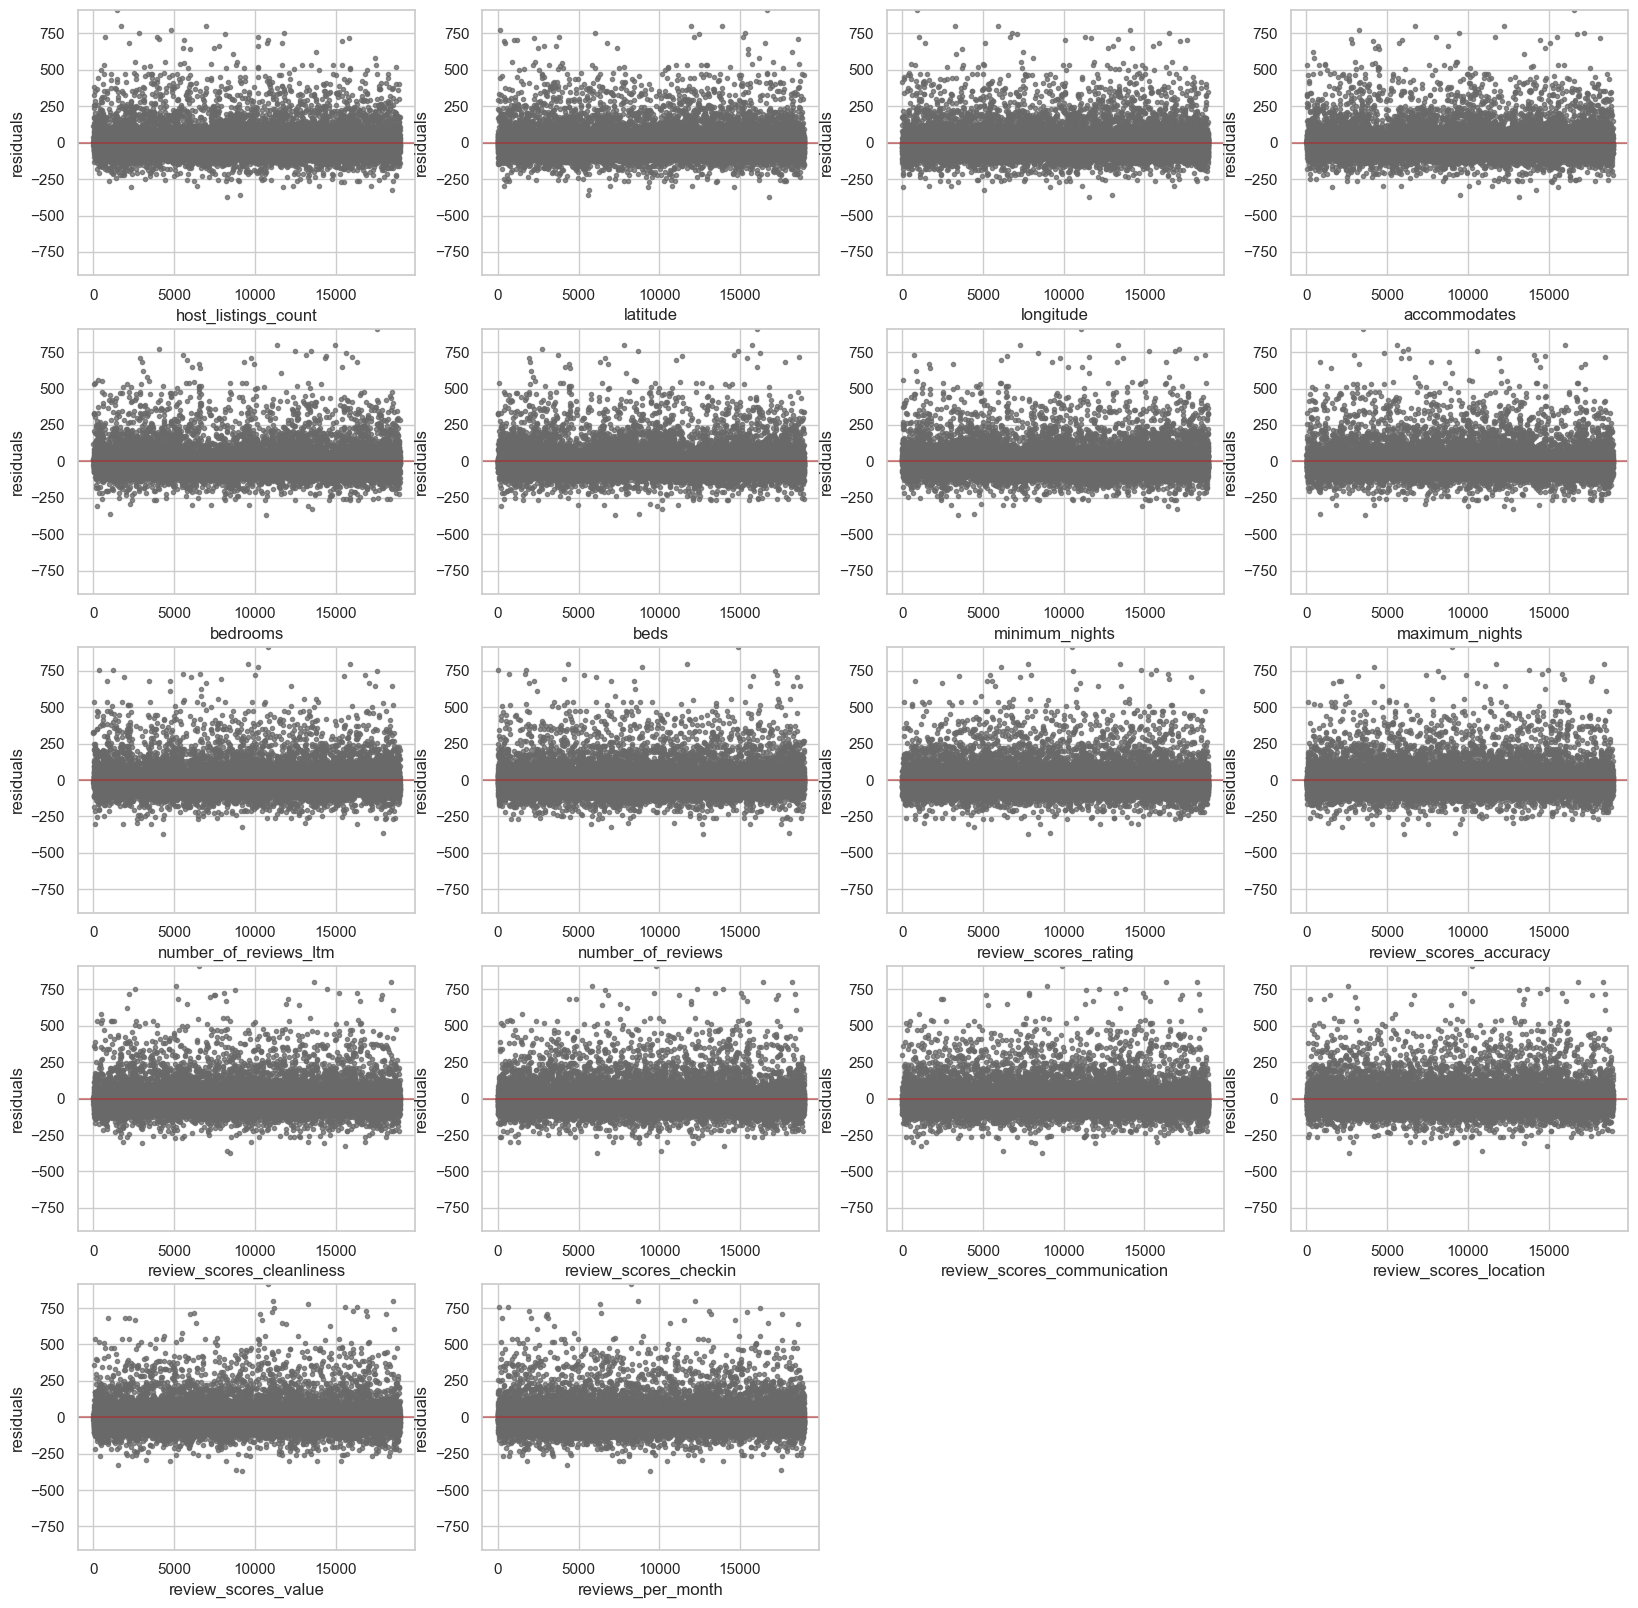

In [69]:
residuals2 = plot_residuals(result2, ["host_listings_count", "latitude", "longitude", 
                                    "accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "number_of_reviews_ltm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness","review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"])

We may need to transform our data for reviews that have an inverse relationship to price. 

In [76]:
df2["recp_beds"] = df2["beds"].apply(np.reciprocal)

/var/folders/hd/mf02nvfn701271s23sy0bsv00000gn/T/ipykernel_1181/4038887348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["recp_beds"] = df2["beds"].apply(np.reciprocal)


Let's create another model with our transformed data.

In [83]:
model = "price ~ host_listings_count + latitude + longitude + accommodates + bedrooms + recp_beds + minimum_nights + maximum_nights + number_of_reviews_ltm + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month"
result3 = models.bootstrap_linear_regression(model, data=df2)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-27391.27,-30986.27,-23448.72
host_listings_count,$\beta_{1}$,0.01,0.01,0.02
latitude,$\beta_{2}$,-595.72,-640.79,-546.12
longitude,$\beta_{3}$,-655.49,-703.97,-602.70
accommodates,$\beta_{4}$,12.47,11.13,13.90
bedrooms,$\beta_{5}$,60.37,57.06,63.78
recp_beds,$\beta_{6}$,9.12,2.47,15.51
minimum_nights,$\beta_{7}$,0.10,0.01,0.17
maximum_nights,$\beta_{8}$,0.00,-0.00,0.00


That didn't help, our R^2 actually went down.

In [80]:
model = "price ~ host_listings_count + latitude + longitude + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews_ltm + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month"
result4 = models.bootstrap_linear_regression(model, data=df2)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-27392.44,-30370.68,-24656.13
host_listings_count,$\beta_{1}$,0.01,0.01,0.02
latitude,$\beta_{2}$,-595.96,-633.17,-549.34
longitude,$\beta_{3}$,-655.82,-696.37,-610.31
accommodates,$\beta_{4}$,14.69,13.80,16.22
bedrooms,$\beta_{5}$,63.02,59.11,65.63
beds,$\beta_{6}$,-8.20,-9.96,-6.57
minimum_nights,$\beta_{7}$,0.10,0.01,0.17
number_of_reviews_ltm,$\beta_{8}$,0.23,0.17,0.33


Let's try a log transformation on price.

In [84]:
df2["log_price"] = df2["price"].apply(np.log)

/var/folders/hd/mf02nvfn701271s23sy0bsv00000gn/T/ipykernel_1181/3162504734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["log_price"] = df2["price"].apply(np.log)


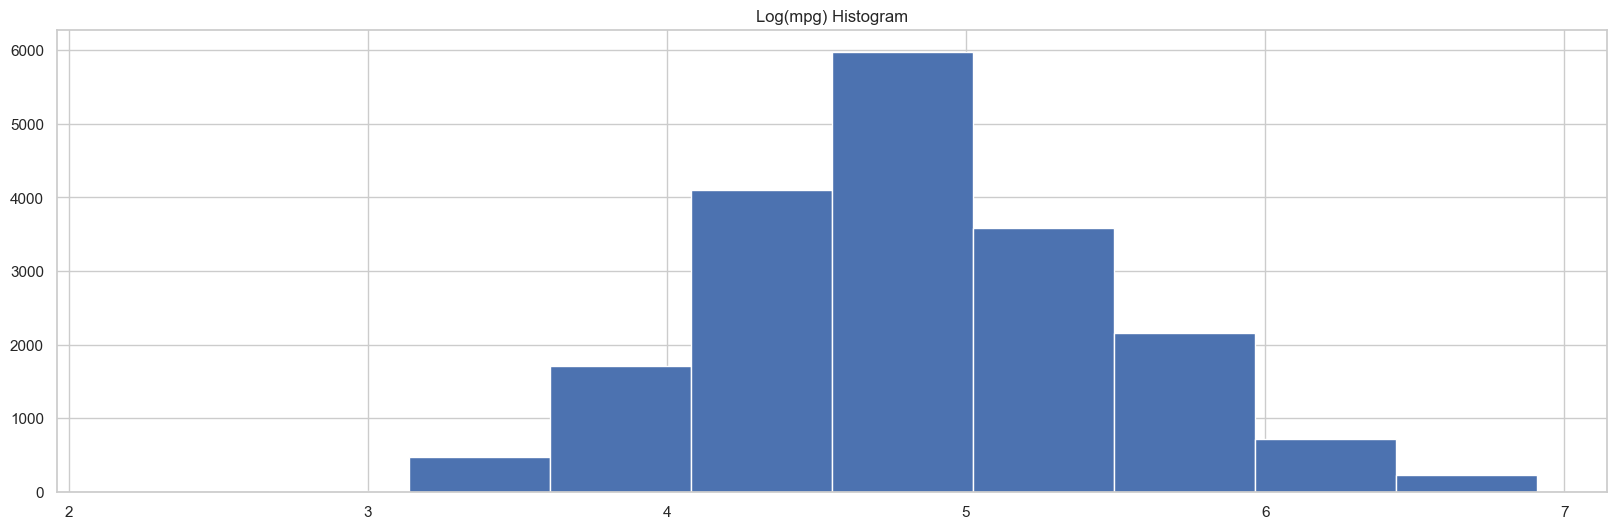

In [86]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(df2.log_price)
axes.set_title("Log(mpg) Histogram")
plt.show()
plt.close()

In [88]:
model = "log_price ~ host_listings_count + latitude + longitude + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews_ltm + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month"
result5 = models.bootstrap_linear_regression(model, data=df2)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-173.50,-192.09,-159.63
host_listings_count,$\beta_{1}$,0.00,0.00,0.00
latitude,$\beta_{2}$,-3.66,-3.93,-3.33
longitude,$\beta_{3}$,-4.14,-4.41,-3.96
accommodates,$\beta_{4}$,0.11,0.11,0.12
bedrooms,$\beta_{5}$,0.29,0.28,0.31
beds,$\beta_{6}$,-0.08,-0.09,-0.07
minimum_nights,$\beta_{7}$,0.00,-0.00,0.00
maximum_nights,$\beta_{8}$,0.00,-0.00,0.00


In [89]:
con.close()